# Simple Benchmark on $loss(x) = \|I - x^T x\|^2$ with and without `adaptive=True`

## Prepare environment

### Install required packages


In [4]:
# Uninstall optax and reinstall just to be sure we're using the latest version
!pip uninstall -q optax -y && pip install -q git+https://github.com/leloykun/optax.git@fc--add-muon
# !pip uninstall -q optax -y && pip install -q -e ~/optax
# Install plotting libraries
!pip install -q matplotlib seaborn psgd_jax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


You can comment out the cell above after running it at least once.

### Import required packages

In [1]:
from functools import partial
from typing import Union, Tuple

import jax
import jax.numpy as jnp
import optax
from optax.contrib import muon

# from psgd_jax.kron import kron as psgd_kron
from psgd_jax.low_rank_approximation import low_rank_approximation as psgd_lra
from psgd_jax.utils import hessian_helper

import matplotlib.pyplot as plt
import seaborn as sns

### Define adaptive scaling by dual norm

In [2]:
from typing import Any, Optional

import chex
from optax import tree_utils as otu
from optax._src import base
from optax._src import combine
from optax._src import numerics
from optax._src import utils
from optax._src import transform
from optax._src.transform import ScaleByAdamState


def scale_by_adam(
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-8,
    eps_root: float = 0.0,
    mu_dtype: Optional[chex.ArrayDType] = None,
    *,
    nesterov: bool = False,
    adaptive: bool = True,
) -> base.GradientTransformation:
  mu_dtype = utils.canonicalize_dtype(mu_dtype)

  def init_fn(params):
    mu = otu.tree_zeros_like(params, dtype=mu_dtype)  # First moment
    nu = otu.tree_zeros_like(params)  # Second moment
    return ScaleByAdamState(count=jnp.zeros([], jnp.int32), mu=mu, nu=nu)

  def update_fn(updates, state, params=None):
    del params
    mu = otu.tree_update_moment(updates, state.mu, b1, 1)
    nu = otu.tree_update_moment_per_elem_norm(updates, state.nu, b2, 2)
    count_inc = numerics.safe_increment(state.count)
    if nesterov:
      mu_hat = jax.tree.map(
          lambda m, g: b1 * m + (1 - b1) * g,
          otu.tree_bias_correction(mu, b1, numerics.safe_increment(count_inc)),
          otu.tree_bias_correction(updates, b1, count_inc),
      )
    else:
      mu_hat = otu.tree_bias_correction(mu, b1, count_inc)
    # Dozat 2016 https://openreview.net/pdf?id=OM0jvwB8jIp57ZJjtNEZ
    # Algorithm 2 further multiplies Adam's standard nu_hat by b2. It is
    # unclear why. Other Nadam implementations also omit the extra b2 factor.
    nu_hat = otu.tree_bias_correction(nu, b2, count_inc)
    updates = jax.tree.map(
        lambda m, v: None if m is None else m / (jnp.sqrt(v + eps_root) + eps),
        mu_hat,
        nu_hat,
        is_leaf=lambda x: x is None,
    )
    if adaptive:
      updates = jax.tree.map(
        lambda x, y: jnp.einsum('ij,ij->', x, y).clip(min=-1., max=1.) * y, mu_hat, updates
      )
    mu = otu.tree_cast(mu, mu_dtype)
    return updates, ScaleByAdamState(count=count_inc, mu=mu, nu=nu)

  return base.GradientTransformation(init_fn, update_fn)


def adam_plus(
    learning_rate: base.ScalarOrSchedule,
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-8,
    eps_root: float = 0.0,
    mu_dtype: Optional[Any] = None,
    *,
    nesterov: bool = False,
    adaptive: bool = True,
) -> base.GradientTransformation:
  return combine.chain(
      scale_by_adam(
          b1=b1,
          b2=b2,
          eps=eps,
          eps_root=eps_root,
          mu_dtype=mu_dtype,
          nesterov=nesterov,
          adaptive=adaptive,
      ),
      transform.scale_by_learning_rate(learning_rate),
  )

### Define adaptive scaling by dual norm for kron

In [64]:
from typing import Any, List, Optional, Union, Callable
from functools import partial
import string
import numpy as np

import chex
import jax
from jax import vmap
import jax.numpy as jnp
import flax.linen as nn
from optax import tree_utils as otu
from optax._src import base, transform, clipping, numerics
from optax._src.numerics import safe_int32_increment
from optax._src.utils import canonicalize_dtype
from optax._src.combine import chain


def precond_update_prob_schedule(
    max_prob=1.0, min_prob=0.03, decay=0.001, flat_start=500
):
    """Anneal preconditioner update probability during beginning of training.

    PSGD benefits from more preconditioner updates at the beginning of training,
    but once the preconditioner is learned the update probability can drop low.

    This schedule is an exponential anneal with a flat start. Default settings keep
    update probability at 1.0 for 250 steps then exponentially anneal down to
    `min_prob` by 4000 steps. Default settings work well for most models and
    training regimes.
    """

    def _schedule(n):
        """Exponential anneal with flat start."""
        return jnp.minimum(
            jnp.maximum(max_prob * jnp.exp(-decay * (n - flat_start)), min_prob),
            max_prob,
        )

    return _schedule


def scale_by_kron(
    b1: float = 0.9,
    preconditioner_update_probability: Union[
        float, Callable[[int], float]
    ] = precond_update_prob_schedule(),
    max_size_triangular: int = 8192,
    min_ndim_triangular: int = 2,
    memory_save_mode: Optional[str] = None,
    momentum_into_precond_update: bool = True,
    preconditioner_lr: float = 0.1,
    preconditioner_init_scale: float = 1.0,
    mu_dtype: Optional[Union[str, jnp.dtype]] = None,
    precond_dtype: Optional[Union[str, jnp.dtype]] = None,
    precond_update_precision: Optional[str] = "tensorfloat32",
    precond_grads_precision: Optional[str] = None,
    scanned_layers: Optional[base.Params] = None,
    lax_map_scanned_layers: bool = False,
    lax_map_batch_size: int = 8,
    adaptive: bool = False,
) -> base.GradientTransformationExtraArgs:
    """
    Implements PSGD Kron from https://github.com/lixilinx/psgd_torch.

    Args:
        b1: float, momentum parameter.
        preconditioner_update_probability: float, probability of updating the
            preconditioner. Default anneals from 1.0 to 0.03 by 4000 steps.
        max_size_triangular: int, max size for dim's preconditioner to be triangular.
        min_ndim_triangular: int, minimum number of dimensions a layer needs to have
            triangular preconditioners.
        memory_save_mode: optional str, None, 'one_diag', or 'all_diag', None is default
            to set all preconditioners to be triangular, 'one_diag' sets the largest
            or last dim to be diagonal per layer, and 'all_diag' sets all preconditioners
            to be diagonal.
        momentum_into_precond_update: bool, whether to send momentum into preconditioner
            update instead of raw gradients.
        preconditioner_lr: float, learning rate for preconditioner.
        preconditioner_init_scale: float, scale for preconditioner initialization.
        mu_dtype: optional str or jnp.dtype, dtype of the momentum accumulator.
            Defaults to the same dtype as the parameters.
        precond_dtype: optional str or jnp.dtype, dtype of the preconditioner.
        precond_update_precision: str, precision for matmul during preconditioner update,
             'bfloat16', 'tensorfloat32', 'float32'.
        precond_grads_precision: str, precision for matmul during preconditioning grads,
             'bfloat16', 'tensorfloat32', 'float32'.
        scanned_layers: optional base.Params, tree of bool same structure as params
            indicating scanned layers. PSGD will vmap over the first dim.
        lax_map_scanned_layers: bool, whether to use lax.map for scanned layers
            instead of vmap. Useful to save memory with large models.
        lax_map_batch_size: int, batch size for lax.map, see JAX docs for more info.

    Returns:
        optax.GradientTransformationExtraArgs
    """
    mu_dtype = canonicalize_dtype(mu_dtype)
    precond_dtype = canonicalize_dtype(precond_dtype)

    def map_fn(do_map, fn, *args):
        """Maybe map a fn along first axis."""
        if do_map:
            if lax_map_scanned_layers:
                return jax.lax.map(
                    lambda xs: fn(*xs),
                    xs=args,
                    batch_size=lax_map_batch_size if lax_map_batch_size > 1 else None,
                )
            else:
                return vmap(fn)(*args)
        else:
            return fn(*args)

    def init_fn(params):
        params = jax.tree.map(
            lambda x: x.unbox() if isinstance(x, nn.Partitioned) else x,
            params,
            is_leaf=lambda v: isinstance(v, (chex.Array, nn.Partitioned)),
        )

        scanned_layers_ = scanned_layers
        if scanned_layers is None:
            scanned_layers_ = jax.tree.map(lambda _: False, params)

        # momentum
        mu = None
        if b1 > 0:
            mu = jax.tree.map(lambda x: jnp.zeros_like(x, dtype=mu_dtype), params)

        # preconditioners
        Qs = [
            _init_Q_exprs(
                t[0] if s else t,
                preconditioner_init_scale,
                max_size_triangular,
                min_ndim_triangular,
                memory_save_mode,
                precond_dtype,
            )[0]
            for t, s in zip(jax.tree.leaves(params), jax.tree.leaves(scanned_layers_))
        ]
        # broadcast for scanned layers
        Qs = [
            (
                jax.tree.map(
                    lambda d: jnp.repeat(jnp.expand_dims(d, 0), t.shape[0], axis=0), q
                )
                if s
                else q
            )
            for q, t, s in zip(
                Qs, jax.tree.leaves(params), jax.tree.leaves(scanned_layers_)
            )
        ]
        Qs = jax.tree.structure(params).unflatten(Qs)

        # Calculate sizes for nu (preconditioner) and mu (momentum)
        Qs_n_elements = sum([q.size for q in jax.tree.leaves(Qs)])
        Qs_size_MB = sum(
            [q.size * q.dtype.itemsize / (2**20) for q in jax.tree.leaves(Qs)]
        )
        if jax.process_index() == 0:
            print(
                f"PSGD Preconditioners size: {Qs_n_elements} elements, "
                f"{Qs_size_MB:.2f} MB"
            )
        if mu is not None:
            mu_n_elements = sum([p.size for p in jax.tree.leaves(mu)])
            mu_size_MB = sum(
                [p.size * p.dtype.itemsize / (2**20) for p in jax.tree.leaves(mu)]
            )
            if jax.process_index() == 0:
                print(
                    f"PSGD Momentum size: {mu_n_elements} elements, {mu_size_MB:.2f} MB"
                )

        # initial state
        return dict(
            count=jnp.zeros([], jnp.int32),
            mu=mu,
            Qs_preconditioners=Qs,
            update_counter=jnp.zeros([], jnp.int32),
        )

    def update_fn(updates: base.Updates, state: dict, params: base.Params = None):
        del params
        count_inc = safe_int32_increment(state["count"])
        key = jax.random.fold_in(jax.random.PRNGKey(5318008), state["count"])

        # account for flax.linen.Partitioned grads and params
        boxed_updates, grads_structure = jax.tree.flatten(
            updates, is_leaf=lambda v: isinstance(v, (chex.Array, nn.Partitioned))
        )
        flax_partitioned = False
        if isinstance(boxed_updates[0], nn.Partitioned):
            flax_partitioned = True
            updates = [u.unbox() for u in boxed_updates]
            updates = grads_structure.unflatten(updates)

        scanned_layers_ = scanned_layers
        if scanned_layers is None:
            scanned_layers_ = jax.tree.map(lambda _: False, updates)

        update_prob_in = preconditioner_update_probability
        if isinstance(preconditioner_update_probability, Callable):
            update_prob_in = preconditioner_update_probability(count_inc)

        # momentum
        mu = None
        momentum_updates = updates
        if state["mu"] is not None:
            mu = otu.tree_update_moment(updates, state["mu"], b1, 1)
            momentum_updates = otu.tree_bias_correction(mu, b1, count_inc)

        # flatten pytrees
        updates, grads_structure = jax.tree.flatten(updates)
        momentum_updates = grads_structure.flatten_up_to(momentum_updates)
        Qs = grads_structure.flatten_up_to(state["Qs_preconditioners"])
        scanned_layers_ = grads_structure.flatten_up_to(scanned_layers_)

        # get einsum expressions
        expressions = [
            _init_Q_exprs(
                t[0] if s else t,
                preconditioner_init_scale,
                max_size_triangular,
                min_ndim_triangular,
                memory_save_mode,
                precond_dtype,
                existing_Q=jax.tree.map(lambda d: d[0], Q) if s else Q,
            )
            for t, s, Q in zip(updates, scanned_layers_, Qs)
        ]

        # maybe update preconditioner
        def update_preconditioner(key, Qs):
            with jax.default_matmul_precision(precond_update_precision):
                if momentum_into_precond_update:
                    precond_updates_in = momentum_updates
                else:
                    precond_updates_in = updates

                # balance preconditioners about every 100 updates
                def balance_Qs(Qs: List[List[jax.Array]]):
                    def _balance_Q(Q: List[jax.Array]):
                        norms = jnp.array(
                            [jnp.max(jnp.abs(q)) for q in Q], dtype=jnp.float32
                        )
                        gmean = jnp.prod(norms) ** (1 / len(norms))
                        to_mul = gmean / norms
                        return [q * x.astype(q.dtype) for q, x in zip(Q, to_mul)]

                    return [
                        map_fn(s, _balance_Q, Q) if len(Q) > 1 else Q
                        for Q, s in zip(Qs, scanned_layers_)
                    ]

                key, subkey = jax.random.split(key)
                do_balances = jax.random.uniform(subkey) < 0.01
                Qs = jax.lax.cond(do_balances, balance_Qs, lambda qs: qs, Qs)

                # create random vectors
                key, subkey = jax.random.split(key)
                Vs_keys = jax.random.split(subkey, len(precond_updates_in))
                Vs = [
                    jax.random.normal(k, shape=g.shape, dtype=g.dtype)
                    for k, g in zip(Vs_keys, precond_updates_in)
                ]

                # damp based on machine precision (f32 probably enough)
                damp_eps = jnp.sqrt(jnp.finfo(jnp.float32).eps)
                precond_updates_in = jax.tree.map(
                    lambda g, v: g + damp_eps.astype(g.dtype) * jnp.mean(jnp.abs(g)) * v,
                    precond_updates_in,
                    Vs,
                )

                # form conjB
                conjBs = [
                    map_fn(s, _conjB, Q, g, v)
                    for s, Q, g, v in zip(scanned_layers_, Qs, precond_updates_in, Vs)
                ]

                # update Qs
                new_Qs = [
                    map_fn(
                        s,
                        partial(
                            _update_precond, exprs=exprs, precond_lr=preconditioner_lr
                        ),
                        Q,
                        g,
                        conjb,
                    )
                    for s, exprs, Q, g, conjb in zip(
                        scanned_layers_, expressions, Qs, precond_updates_in, conjBs
                    )
                ]

                new_Qs = otu.tree_cast(new_Qs, precond_dtype)
                return new_Qs

        # update preconditioner deterministically
        update_counter_inc = safe_int32_increment(state["update_counter"])
        do_update = update_counter_inc >= 1 / update_prob_in
        update_counter_inc = jnp.where(do_update, 0, update_counter_inc)
        key, subkey = jax.random.split(key)
        Qs = jax.lax.cond(do_update, update_preconditioner, lambda _, qs: qs, subkey, Qs)

        # precondition gradients
        with jax.default_matmul_precision(precond_grads_precision):
            precond_gs = [
                map_fn(s, partial(_precond_grad, exprs=exprs), Q, g)
                for s, exprs, Q, g in zip(
                    scanned_layers_, expressions, Qs, momentum_updates
                )
            ]

            ########## adaptive! ###############
            if adaptive:
                precond_gs = jax.tree.map(
                    lambda x, y: jnp.einsum('ij,ij->', x, y).clip(min=-1., max=1.) * y, momentum_updates, precond_gs
                )
            ####################################

        # RMS of pre_grad should be 1.0, so let's cap at 1.1
        def _clip_fn(u):
            clip_denom = jnp.maximum(
                1.0,
                jnp.sqrt(jnp.mean(numerics.abs_sq(u))) / 1.1)
            return u / clip_denom

        precond_gs = jax.tree.map(_clip_fn, precond_gs)

        # box preconditioned grads
        if flax_partitioned:
            precond_gs = [
                u.replace_boxed(pg) for u, pg in zip(boxed_updates, precond_gs)
            ]

        # unflatten pytrees
        updates = grads_structure.unflatten(precond_gs)
        Qs = grads_structure.unflatten(Qs)

        # dtypes and new state
        mu = otu.tree_cast(mu, mu_dtype)
        Qs = otu.tree_cast(Qs, precond_dtype)
        state = dict(
            count=count_inc,
            mu=mu,
            Qs_preconditioners=Qs,
            update_counter=update_counter_inc,
        )

        return updates, state

    return base.GradientTransformationExtraArgs(init_fn, update_fn)


def psgd_kron(
    learning_rate: Union[float, Callable[[int], float]] = 0.001,
    b1: float = 0.9,
    weight_decay: float = 0.0,
    weight_decay_mask: Optional[Union[Any, Callable[[base.Params], Any]]] = None,
    preconditioner_update_probability: Union[
        float, Callable[[int], float]
    ] = precond_update_prob_schedule(),
    max_size_triangular: int = 8192,
    min_ndim_triangular: int = 2,
    memory_save_mode: Optional[str] = None,
    momentum_into_precond_update: bool = True,
    preconditioner_lr: float = 0.1,
    preconditioner_init_scale: float = 1.0,
    mu_dtype: Optional[Union[str, jnp.dtype]] = None,
    precond_dtype: Optional[Union[str, jnp.dtype]] = None,
    precond_update_precision: Optional[str] = "tensorfloat32",
    precond_grads_precision: Optional[str] = None,
    scanned_layers: Optional[base.Params] = None,
    lax_map_scanned_layers: bool = False,
    lax_map_batch_size: int = 8,
    adaptive: bool = False,
) -> base.GradientTransformationExtraArgs:
    """
    Implements PSGD Kron from https://github.com/lixilinx/psgd_torch.

    Args:
        learning_rate: float or callable, learning rate.
        b1: float, momentum parameter.
        weight_decay: float, weight decay.
        weight_decay_mask: optional Any or callable, pytree of bool same structure
            as params with weight decay applied to True elements.
        preconditioner_update_probability: float, probability of updating the
            preconditioner. Default anneals from 1.0 to 0.03 by 4000 steps.
        max_size_triangular: int, max size for dim's preconditioner to be triangular.
        min_ndim_triangular: int, minimum number of dimensions a layer needs to have
            triangular preconditioners.
        memory_save_mode: optional str, None, 'one_diag', or 'all_diag', None is default
            to set all preconditioners to be triangular. 'one_diag' sets only the largest
            or last dim in a layer to be diagonal, and 'all_diag' sets all preconditioners
            to be diagonal.
        momentum_into_precond_update: bool, whether to send momentum into preconditioner
            update instead of raw gradients.
        preconditioner_lr: float, learning rate for preconditioner.
        preconditioner_init_scale: float, scale for preconditioner initialization.
        mu_dtype: optional str or jnp.dtype, dtype of the momentum accumulator.
            Defaults to the same dtype as the parameters.
        precond_dtype: optional str or jnp.dtype, dtype of the preconditioner.
        precond_update_precision: str, precision for matmul during preconditioner update,
            'bfloat16', 'tensorfloat32', 'float32'.
        precond_grads_precision: str, precision for matmul during preconditioning grads,
            'bfloat16', 'tensorfloat32', 'float32'.
        scanned_layers: optional base.Params, tree of bool same structure as params
            indicating scanned layers. PSGD will vmap over the first dim.
        lax_map_scanned_layers: bool, whether to use lax.map for scanned layers
            instead of vmap. Useful to save memory with large models.
        lax_map_batch_size: int, batch size for lax.map, see JAX docs for more info.

    Returns:
        optax.GradientTransformationExtraArgs
    """
    optimizer = [
        scale_by_kron(
            b1=b1,
            preconditioner_update_probability=preconditioner_update_probability,
            max_size_triangular=max_size_triangular,
            min_ndim_triangular=min_ndim_triangular,
            memory_save_mode=memory_save_mode,
            momentum_into_precond_update=momentum_into_precond_update,
            preconditioner_lr=preconditioner_lr,
            preconditioner_init_scale=preconditioner_init_scale,
            mu_dtype=mu_dtype,
            precond_dtype=precond_dtype,
            precond_update_precision=precond_update_precision,
            precond_grads_precision=precond_grads_precision,
            scanned_layers=scanned_layers,
            lax_map_scanned_layers=lax_map_scanned_layers,
            lax_map_batch_size=lax_map_batch_size,
            adaptive=adaptive,
        )
    ]
    if weight_decay > 0.0:
        optimizer.append(transform.add_decayed_weights(weight_decay, weight_decay_mask))
    optimizer.append(transform.scale_by_learning_rate(learning_rate))
    return chain(*optimizer)


def _add_tiny(x):
    return x + jnp.finfo(x.dtype).tiny


def _norm_lower_bound(A: jax.Array):
    """Returns a cheap lower bound for the spectral norm of A.

    Numerical results on random matrices with a wide range of distributions and
    sizes suggest, norm(A) <= sqrt(2) * norm_lower_bound(A). Looks to be a very
    tight lower bound.
    """
    max_abs = jnp.max(jnp.abs(A))

    def calc(A):
        A = A / max_abs
        A_conj = A.conj()

        aa = jnp.real(A * A_conj)

        aa_sum0 = jnp.sum(aa, axis=0)
        aa_sum1 = jnp.sum(aa, axis=1)
        i = jnp.argmax(aa_sum0, 0)
        j = jnp.argmax(aa_sum1, 0)
        value0 = jax.lax.dynamic_index_in_dim(aa_sum0, i, 0, keepdims=False)
        value1 = jax.lax.dynamic_index_in_dim(aa_sum1, j, 0, keepdims=False)

        def gt_branch():
            x = jax.lax.dynamic_index_in_dim(A, i, 1, keepdims=False)
            x = x.conj() @ A
            return max_abs * jnp.linalg.norm((x / jnp.linalg.norm(x)) @ A_conj.T)

        def le_branch():
            x = jax.lax.dynamic_index_in_dim(A, j, 0, keepdims=False)
            x = A @ x.conj()
            return max_abs * jnp.linalg.norm(A_conj.T @ (x / jnp.linalg.norm(x)))

        return jax.lax.cond(value0 > value1, gt_branch, le_branch)

    def no_calc(_):
        return max_abs

    return jax.lax.cond(max_abs > 0, calc, no_calc, A)


def _init_Q_exprs(
    t, scale, max_size, min_ndim_triangular, memory_save_mode, dtype, existing_Q=None
):
    """For a scalar or tensor `t`, we initialize its preconditioner `Q` and
    reusable contraction expressions for updating `Q` and preconditioning gradient.
    """
    letters = string.ascii_lowercase + string.ascii_uppercase

    shape = t.shape
    if len(shape) == 0:  # scalar
        Q = (
            [scale * jnp.ones_like(t, dtype=dtype)]
            if existing_Q is None
            else existing_Q
        )
        exprA = ",->"
        exprGs = [",->"]
        exprP = ",,->"
    else:  # tensor
        if len(shape) > 13:
            raise ValueError(
                f"Got tensor with dim {len(t.shape)}; Einstein runs out of letters!"
            )

        scale = scale ** (1 / len(shape))

        if memory_save_mode is None:
            dim_diag = [False for _ in shape]
        elif memory_save_mode == "one_diag":
            rev_sorted_dims = np.argsort(shape)[::-1]
            dim_diag = [False for _ in shape]
            dim_diag[rev_sorted_dims[0]] = True
        elif memory_save_mode == "all_diag":
            dim_diag = [True for _ in shape]
        else:
            raise ValueError(
                f"Invalid memory_save_mode: {memory_save_mode}, must be one of "
                "[None, 'one_diag', 'all_diag']"
            )

        Q = [] if existing_Q is None else existing_Q
        piece1A, piece2A, piece3A = ([], "", "")
        exprGs = []
        piece1P, piece2P, piece3P, piece4P = ([], [], "", "")
        for i, (size, dim_d) in enumerate(zip(shape, dim_diag)):
            if (
                size == 1
                or size > max_size
                or len(shape) < min_ndim_triangular
                or dim_d
            ):
                # use diagonal matrix as preconditioner for this dim
                if existing_Q is None:
                    Q.append(scale * jnp.ones(size, dtype=dtype))

                piece1A.append(letters[i])
                piece2A = piece2A + letters[i]
                piece3A = piece3A + letters[i]

                piece1 = "".join(
                    [
                        (letters[i + 13] if j == i else letters[j])
                        for j in range(len(shape))
                    ]
                )
                exprGs.append(piece1 + "," + piece1 + "->" + letters[i + 13])

                piece1P.append(letters[i + 13])
                piece2P.append(letters[i + 13])
                piece3P = piece3P + letters[i + 13]
                piece4P = piece4P + letters[i + 13]
            else:
                # use triangular matrix as preconditioner for this dim
                if existing_Q is None:
                    Q.append(scale * jnp.eye(size, dtype=dtype))

                piece1A.append(letters[i] + letters[i + 13])
                piece2A = piece2A + letters[i + 13]
                piece3A = piece3A + letters[i]

                piece1 = "".join(
                    [
                        (letters[i + 13] if j == i else letters[j])
                        for j in range(len(shape))
                    ]
                )
                piece2 = "".join(
                    [
                        (letters[i + 26] if j == i else letters[j])
                        for j in range(len(shape))
                    ]
                )
                exprGs.append(
                    piece1 + "," + piece2 + "->" + letters[i + 13] + letters[i + 26]
                )

                a, b, c = (letters[i], letters[i + 13], letters[i + 26])
                piece1P.append(a + b)
                piece2P.append(a + c)
                piece3P = piece3P + c
                piece4P = piece4P + b

        exprA = ",".join(piece1A) + "," + piece2A + "->" + piece3A
        exprP = (
            ",".join(piece1P) + "," + ",".join(piece2P) + "," + piece3P + "->" + piece4P
        )

    exprGs = tuple(exprGs)
    if existing_Q is not None:
        return exprA, exprGs, exprP
    return [Q, (exprA, exprGs, exprP)]


def _solve_triangular_right(X, A):
    """Compute X @ inv(A).

    A triangular solve has roughly the same complexity as a matmul.
    """
    X_ndim = X.ndim
    if X_ndim < 2:
        X = X[None, :]

    dtype_in = jnp.promote_types(A.dtype, X.dtype)
    A, X = A.astype(dtype_in), X.astype(dtype_in)
    leading_dims = 0
    if X.ndim > 2:
        leading_dims = X.ndim - 2
    solve_fn = partial(jax.lax.linalg.triangular_solve, left_side=False, lower=False)
    for _ in range(leading_dims):
        solve_fn = vmap(solve_fn, in_axes=(None, 0))
    solution = solve_fn(A, X)

    if X_ndim < 2:
        return solution[0]
    return solution


def _conjB(Q, G, V):
    """Compute conjB."""
    order = G.ndim
    p = list(range(order))
    conjB = jnp.transpose(V.conj(), p[1:] + p[:1])
    for i, q in enumerate(Q):
        conjB = conjB / q if q.ndim < 2 else _solve_triangular_right(conjB, q)
        if i < order - 1:
            conjB = jnp.swapaxes(conjB, i, order - 1)
    return conjB


def _update_precond(Q, G, conjB, exprs, precond_lr):
    """Compute A and update Q."""
    exprA, exprGs, _ = exprs

    A = jnp.einsum(exprA, *Q, G)

    A_conj = A.conj()
    conjB_conj = conjB.conj()

    def _update_single_q(i, q):
        term1 = jnp.einsum(exprGs[i], A, A_conj)
        term2 = jnp.einsum(exprGs[i], conjB_conj, conjB)

        tmp = term1 - term2
        tmp *= precond_lr
        if q.ndim < 2:
            tmp *= q
            tmp /= _add_tiny(jnp.max(jnp.abs(term1 + term2)))
            q -= tmp
        else:
            tmp = jnp.triu(tmp)
            tmp /= _add_tiny(_norm_lower_bound(term1 + term2))
            tmp @= q
            q -= tmp
        return q

    return [_update_single_q(i, q) for i, q in enumerate(Q)]


def _precond_grad(Q, G, exprs):
    """Precondition gradient G with preconditioner Q."""
    exprP = exprs[-1]
    return jnp.einsum(exprP, *[q.conj() for q in Q], *Q, G)

## Benchmark

### Utils

In [65]:
def loss(x: jnp.ndarray, n: int):
    return jnp.linalg.norm(jnp.eye(n, dtype=x.dtype) - x.T @ x)**2

loss_and_grad_fn = jax.jit(jax.value_and_grad(loss), static_argnames=("n",))
loss_fn = loss

In [70]:
@partial(jax.jit, static_argnums=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
def train(
    x: jnp.ndarray,
    n: int = 2,
    dtype: jnp.dtype = jnp.float32,
    optimizer_class: str = "muon",  # ["muon", "adam", "psgd_kron", "psgd_lra", "psgd_lra_Hess"]
    num_iterations: int = 100,
    learning_rate: float = 0.001,
    ns_coeffs: Union[
      Tuple[float, float, float],
      Tuple[Tuple[float, float, float], ...],
    ] = (3.4445, -4.7750, 2.0315),
    ns_steps: int = 5,
    beta: float = 0.95,
    nesterov: bool = True,
    adaptive: bool = False,
):
    x = x.astype(dtype)
    if optimizer_class == "muon":
        optimizer = muon(
            learning_rate=learning_rate,
            ns_coeffs=ns_coeffs,
            ns_steps=ns_steps,
            beta=beta,
            nesterov=nesterov,
            adaptive=adaptive,
        )
    elif optimizer_class == "adam":
        optimizer = adam_plus(
            learning_rate=learning_rate,
            b1=beta,
            b2=beta,
            nesterov=nesterov,
            adaptive=adaptive,
        )
    elif optimizer_class == "psgd_kron":
        optimizer = psgd_kron(
            learning_rate=0.05,  # adam lr / 2
            b1=0.85,  # slightly lower momentum seems to speed things up, probably somewhat imitates the tightness of nesterov
            preconditioner_update_probability=1.0,
            mu_dtype="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precond_dtype="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precond_update_precision="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precond_grads_precision="bfloat16" if dtype == jnp.bfloat16 else "float32",
            adaptive=adaptive,  # adaptive!
        )
    elif optimizer_class == "psgd_lra":
        optimizer = psgd_lra(
            learning_rate=0.05,
            uvd_rank_of_approximation=4,
            mu_dtype="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precision="bfloat16" if dtype == jnp.bfloat16 else "float32",
            update_global_norm_clip = n,  # might not be needed
        )
    elif optimizer_class == "psgd_lra_Hess":
        optimizer = psgd_lra(
            learning_rate=0.5,  # 10x higher lr for hessian
            b1=0.0,  # momentum not needed with hessian
            uvd_rank_of_approximation=4,
            precond_lr=1.0,  # can use higher precond lr with hessian
            mu_dtype="bfloat16" if dtype == jnp.bfloat16 else "float32",
            precision="bfloat16" if dtype == jnp.bfloat16 else "float32",
            update_global_norm_clip = n,  # might not be needed
        )
    opt_state = optimizer.init(x)

    @jax.jit
    def body_fn(values: tuple[jnp.ndarray, optax.OptState], _):
        x, opt_state, rng_key, step = values
        step += 1
        if optimizer_class == "psgd_lra_Hess":
            rng_key, subkey = jax.random.split(rng_key)
            loss, grad, hvp, vector, update_precond = hessian_helper(
                rng_key, step, jax.jit(loss_fn, static_argnums=(1,)), x, (n,), False, 1.0
            )
            updates, opt_state = optimizer.update(
                grad, opt_state, None, Hvp=hvp, vector=vector, update_preconditioner=update_precond
            )
        else:
            loss, grad = loss_and_grad_fn(x, n)
            updates, opt_state = optimizer.update(grad, opt_state, x)
        new_x = optax.apply_updates(x, updates)
        return (new_x, opt_state, rng_key, step), loss

    _, losses = jax.lax.scan(body_fn, (x, opt_state, jax.random.PRNGKey(0), 0), length=num_iterations)

    return losses

batch_train = jax.vmap(train, in_axes=(0, None, None, None, None, None, None, None, None, None, None))

### Benchmark optimizer variants

In [71]:
def benchmark_optimizer_variants(
    savefile: str,
    b: int=100,
    n: int=2,
    dtype: jnp.dtype=jnp.float32,
    num_iterations: int=100,
    learning_rate: float=0.1,
    ns_steps: int=5,
    beta: float=0.0,
):
    key = jax.random.PRNGKey(0)
    X = jax.random.uniform(key, shape=(b, n, n), dtype=dtype)

    results = {}
    for optimizer_class in ["muon", "adam", "psgd_kron", "psgd_lra", "psgd_lra_Hess"]:
        for adaptive in [False, True]:
            if optimizer_class in ["psgd_lra", "psgd_lra_Hess"] and adaptive:
                continue
            ns_coeffs = (3.4445, -4.7750, 2.0315)
            losses = batch_train(
                X,
                n,
                dtype,
                optimizer_class,
                num_iterations,
                learning_rate,
                ns_coeffs,
                ns_steps,
                beta,
                True,
                adaptive,
            )
            losses = jnp.where(jnp.isnan(losses), 0.0, losses)
            results[(optimizer_class, adaptive)] = losses.astype(jnp.float32)

    palette = sns.color_palette("Paired", n_colors=len(results))
    sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
    plt.figure(figsize=(12, 8))
    for idx, ((optimizer_class, adaptive), all_losses) in enumerate(results.items()):
        for losses in all_losses:
            sns.lineplot(
                losses,
                alpha=0.02,
                color=palette[idx],
            )
        x = jnp.arange(1, num_iterations+1)
        median_losses = jnp.median(all_losses, axis=0)
        sns.lineplot(
            x=x,
            y=median_losses,
            label=f"{optimizer_class.title()}{'; adaptive' if adaptive else '          '}",
            # linestyle="--" if optimized else "-",
            color=palette[idx],
            linewidth=2.5,
        )
    plt.title(f"Optimizer Variants (beta={beta:.3f}, lr={learning_rate}, dtype={dtype.dtype})\n$loss(x) = || I - x^T x ||^2$")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    if dtype == jnp.bfloat16:
        plt.ylim(bottom=1e-7)
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()

PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
PSGD: Using momentum.


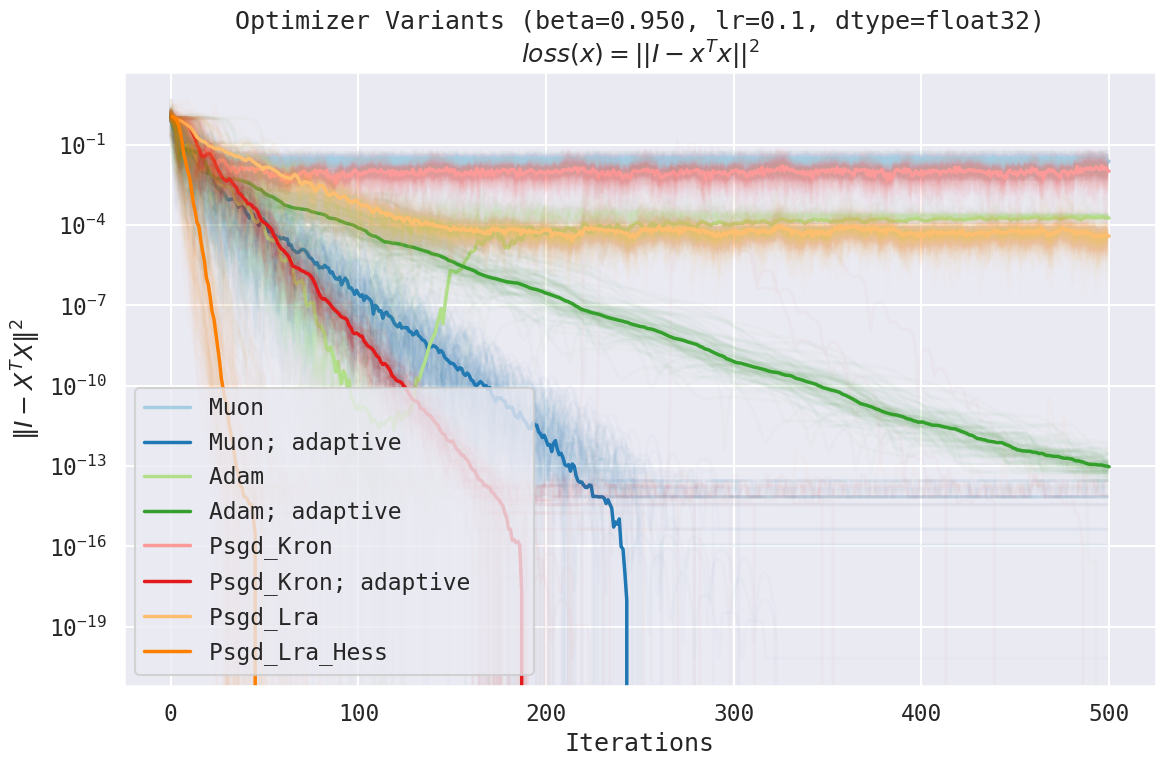

In [72]:
benchmark_optimizer_variants(
    savefile="/content/optimizer_variants.png",
    num_iterations=500,
    learning_rate=1e-1,
    beta=0.95,
)

PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
PSGD Preconditioners size: 8 elements, 0.00 MB
PSGD Momentum size: 4 elements, 0.00 MB
PSGD: Using momentum.


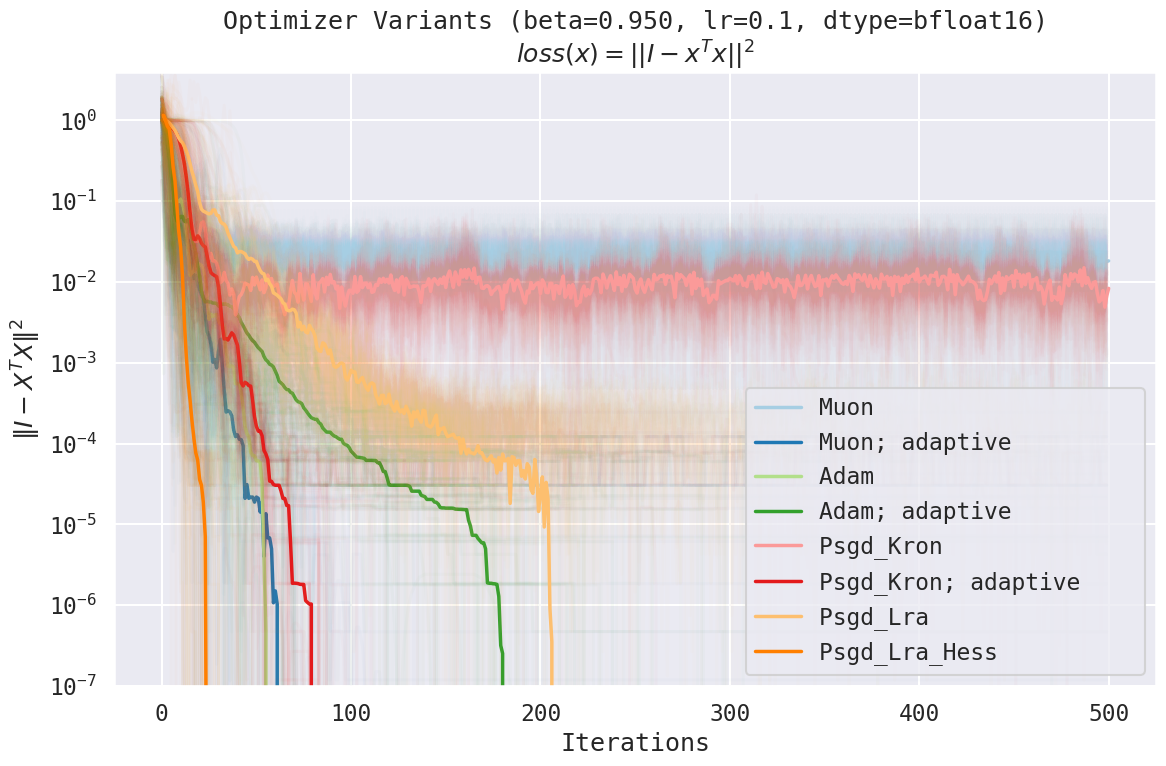

In [73]:
benchmark_optimizer_variants(
    savefile="/content/optimizer_variants_bfloat16.png",
    dtype=jnp.bfloat16,
    num_iterations=500,
    learning_rate=1e-1,
    beta=0.95,
)

### Benchmark by momentum decay

In [ ]:
def benchmark_muon_by_momentum_decay(
    savefile: str,
    b: int=100,
    n: int=2,
    dtype: jnp.dtype=jnp.float32,
    adaptive: bool=False,
    num_iterations: int=100,
    learning_rate: float=0.1,
    ns_steps: int=5,
    optimize_coeffs: bool=False,
):
    key = jax.random.PRNGKey(0)
    X = jax.random.uniform(key, shape=(b, n, n), dtype=dtype)

    betas = jnp.linspace(0, 0.999, 10).tolist()
    betas.insert(-1, 0.95)

    ns_coeffs=(
        (3.4445, -4.7750, 2.0315)
        if not optimize_coeffs
        else (
            (2.9145, -4.3663, 2.4515),
            (2.9131, -4.3582, 2.4446),
            (2.9030, -4.3145, 2.4106),
            (2.8317, -4.0251, 2.1928),
            (2.8392, -3.3535, 1.5149),
        )
    )

    results = {}
    for beta in betas:
        losses = batch_train(
            X,
            n,
            dtype,
            "muon",
            num_iterations,
            learning_rate,
            ns_coeffs,
            ns_steps,
            beta,
            True,
            adaptive,
        )
        losses: jnp.ndarray = jnp.where(jnp.isnan(losses), 0.0, losses)
        results[beta] = losses.astype(jnp.float32)

    palette = sns.color_palette("crest", len(betas))
    sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
    plt.figure(figsize=(12, 8))
    for idx, (beta, all_losses) in enumerate(results.items()):
        x = jnp.arange(1, num_iterations+1)
        median_losses = jnp.median(all_losses, axis=0)
        sns.lineplot(
            x=x,
            y=median_losses,
            label=f"$\\beta$={beta:.3f}{'**' if beta == 0.95 else ''}",
            color=palette[idx],
            linewidth=2.5,
        )
        for losses in all_losses:
            sns.lineplot(
                losses,
                alpha=0.02,
                color=palette[idx],
            )
    plt.title(f"{'Adaptive ' if adaptive else ''}Muon: Limitation of Momentum (lr={learning_rate}, dtype={dtype.dtype})")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    # plt.ylim(bottom=1e-16, top=1e2)
    plt.yscale("log")
    plt.legend(title=f"$\\beta$ Values", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()
    return results

In [ ]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/muon_by_momentum_decay.png",
    adaptive=False,
    optimize_coeffs=False,
)

In [ ]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay.png",
    adaptive=True,
    optimize_coeffs=False,
)

In [ ]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay_optimized_coeffs_opt.png",
    adaptive=True,
    optimize_coeffs=True,
)

In [ ]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay_bfloat16.png",
    adaptive=True,
    optimize_coeffs=False,
    dtype=jnp.bfloat16,
)

In [ ]:
_ = benchmark_muon_by_momentum_decay(
    savefile="images/adaptive_muon_by_momentum_decay_optimized_coeffs_opt_bfloat16.png",
    adaptive=True,
    optimize_coeffs=True,
    dtype=jnp.bfloat16,
)

### Benchmark convergence/divergence rates

In [ ]:
def benchmark_stability(
    savefile: str,
    b: int=100,
    n: int=2,
    dtype: jnp.dtype=jnp.float32,
    adaptive: bool=False,
    num_iterations: int=100,
    learning_rate: float=0.1,
    ns_steps: int=5,
    optimize_coeffs: bool=False,
):
    key = jax.random.PRNGKey(0)
    X = jax.random.uniform(key, shape=(b, n, n), dtype=dtype)

In [ ]:
key = jax.random.PRNGKey(0)

b = 10000
n = 2
# dtype = jnp.float32
dtype = jnp.bfloat16
X = jax.random.normal(key, shape=(b, n, n), dtype=dtype)

In [ ]:
num_iterations = 500
ns_coeffs = (3.4445, -4.7750, 2.0315)
ns_steps = 5
beta = 0.95
nesterov = True

lr_batch_train = jax.vmap(batch_train, in_axes=(None, None, None, None, None, 0, None, None, None, None, None))
learning_rates = jnp.logspace(-3, 0, 10, base=10)

results = {}
for optimizer_class in ["muon", "adam", "psgd_kron", "psgd_lra"]:
    for adaptive in [False, True]:
        if optimizer_class in ["psgd_kron", "psgd_lra"] and adaptive:
            continue
        losses = lr_batch_train(
            X,
            n,
            dtype,
            optimizer_class,
            num_iterations,
            learning_rates,
            ns_coeffs,
            ns_steps,
            beta,
            nesterov,
            adaptive,
        )
        losses = jnp.where(jnp.isnan(losses), 0.0, losses)

        divergence_ratio = (losses[:,:,-1] > 1).sum(axis=1) / b
        soft_convergence_ratio = (losses[:,:,-1] < 1e-3).sum(axis=1) / b
        hard_convergence_ratio = (losses[:,:,-1] < 1e-6).sum(axis=1) / b
        results[(optimizer_class, adaptive)] = (
            divergence_ratio,
            soft_convergence_ratio,
            hard_convergence_ratio,
        )

In [ ]:
palette = sns.color_palette("Paired", n_colors=len(results))
sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
plt.figure(figsize=(12, 8))
for idx, ((optimizer_class, adaptive), (divergence_ratio, soft_convergence_ratio, hard_convergence_ratio)) in enumerate(results.items()):
    sns.lineplot(
        x=learning_rates,
        y=soft_convergence_ratio,
        label=f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}",
        color=palette[idx],
    )

plt.title("Effect of Scaling by the Update's Dual Norm\non Convergence for Difference Optimizers\n$loss(x) = || I - x^T x ||^2$")
plt.ylabel("% Converged (Loss < 1e-3)")
plt.ylim(-0.1, 1.1)
plt.yticks(jnp.linspace(0., 1., 6), jnp.linspace(0, 100, 6, dtype=int))
plt.xlabel("Learning Rate")
plt.xticks(learning_rates)
plt.xscale("log")
plt.legend()
# plt.tight_layout()
# plt.savefig(savefile)
plt.show()

In [ ]:
palette = sns.color_palette("Paired", n_colors=len(results))
sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
plt.figure(figsize=(12, 8))
for idx, ((optimizer_class, adaptive), (divergence_ratio, soft_convergence_ratio, hard_convergence_ratio)) in enumerate(results.items()):
    sns.lineplot(
        x=learning_rates,
        y=hard_convergence_ratio,
        label=f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}",
        color=palette[idx],
    )

plt.title("Effect of Scaling by the Update's Dual Norm\non Convergence for Difference Optimizers\n$loss(x) = || I - x^T x ||^2$")
plt.ylabel("% Converged (Loss < 1e-6)")
plt.ylim(-0.1, 1.1)
plt.yticks(jnp.linspace(0., 1., 6), jnp.linspace(0, 100, 6, dtype=int))
plt.xlabel("Learning Rate")
plt.xticks(learning_rates)
plt.xscale("log")
plt.legend()
# plt.tight_layout()
# plt.savefig(savefile)
plt.show()

In [ ]:
palette = sns.color_palette("Paired", n_colors=len(results))
sns.set_theme(font="monospace", style="darkgrid", context="talk", palette=palette)
plt.figure(figsize=(12, 8))
for idx, ((optimizer_class, adaptive), (divergence_ratio, soft_convergence_ratio, hard_convergence_ratio)) in enumerate(results.items()):
    sns.lineplot(
        x=learning_rates,
        y=divergence_ratio,
        label=f"{optimizer_class.title()}{'; adaptive' if adaptive else ''}",
        color=palette[idx],
    )

plt.title("Effect of Scaling by the Update's Dual Norm\non Divergence for Difference Optimizers\n$loss(x) = || I - x^T x ||^2$")
plt.ylabel("% Diverged")
plt.ylim(-0.1, 1.1)
plt.yticks(jnp.linspace(0., 1., 6), jnp.linspace(0, 100, 6, dtype=int))
plt.xlabel("Learning Rate")
plt.xticks(learning_rates)
plt.xscale("log")
plt.legend()
# plt.tight_layout()
# plt.savefig(savefile)
plt.show()

In [ ]:
for optimizer_class in ["muon", "adam", "psgd_kron", "psgd_lra"]:
    for adaptive in [False, True]:
        if optimizer_class in ["psgd_kron", "psgd_lra"] and adaptive:
            continue
        print(f"{optimizer_class = }, {adaptive = }")
        print("   lr   | # >1  | # <1e-3 | # <1e-6")
        print("------+-------+---------+--------")
        for lr in jnp.logspace(-3, 0, 10, base=10):
            lr = lr.item()
            results = batch_train(
                X,
                n,
                dtype,
                optimizer_class,
                num_iterations,
                lr,
                ns_coeffs,
                ns_steps,
                beta,
                nesterov,
                adaptive,
            )
            results = jnp.where(jnp.isnan(results), 0.0, results)
            print(f"{lr:.1e} | {(results[:,-1] > 1).sum():<5} | {(results[:,-1] < 1e-3).sum():<7} | {(results[:,-1] < 1e-6).sum()}")
        print()